In [182]:
import matplotlib

In [251]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader

datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters-complete', '8_19')
num_filters = 8
savepath = 'vae_' + str(num_filters) + '.pt'

def get_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    # import pdb; pdb.set_trace()
    for i in range(num_filters):
      weight_dataset.append(filter['0.weight'][i][0])
  return weight_dataset

num_images = len(os.listdir(filterpath))
dataset = get_dataset()
dataset = torch.stack(dataset, dim=0)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

vae_batch_size = 100

x_dim  = 25
hidden_dim1 = 20
hidden_dim2 = 20
hidden_dim3 = 20
hidden_dim4 = 20
latent_dim = 10

kl_start = 0
warm_up = 50000

lr = 1e-2

epochs = 100

kwargs = {'num_workers': 1} 

train_dataset = dataset.to(device)
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True, **kwargs)

1364it [00:01, 1237.24it/s]


In [252]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_input4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        h_       = self.tanh(self.FC_input3(h_))
        h_       = self.tanh(self.FC_input4(h_))

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim1)
        self.FC_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_output = nn.Linear(hidden_dim4, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        h     = self.tanh(self.FC_hidden3(h))
        h     = self.tanh(self.FC_hidden4(h))

        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)
criterion = torch.nn.MSELoss()

In [253]:
kl_weight = kl_start
anneal_rate = (1.0 - kl_start) / (warm_up * (len(train_dataset) / vae_batch_size))

In [254]:
optimizer = Adam(model.parameters(), lr=lr)

model.train()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=20, bias=True)
    (FC_input2): Linear(in_features=20, out_features=20, bias=True)
    (FC_input3): Linear(in_features=20, out_features=20, bias=True)
    (FC_input4): Linear(in_features=20, out_features=20, bias=True)
    (FC_mean): Linear(in_features=20, out_features=10, bias=True)
    (FC_var): Linear(in_features=20, out_features=10, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=10, out_features=20, bias=True)
    (FC_hidden2): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden3): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden4): Linear(in_features=20, out_features=20, bias=True)
    (FC_output): Linear(in_features=20, out_features=25, bias=True)
    (tanh): Tanh()
  )
)

In [255]:
reproduction_losses = []
for epoch in range(epochs):
    overall_loss = 0
    reproduction_loss_epoch = 0
    KL_loss_epoch = 0
    for batch_idx, x in enumerate(train_loader):

        model.train()
        x = x.view(x.shape[0], x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        
        kl_weight = min(1.0, kl_weight + anneal_rate)

        reproduction_loss = torch.mean(torch.norm(x_hat - x, dim=1) ** 2)
        KL_loss      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        loss_val = reproduction_loss + kl_weight * KL_loss
        
        overall_loss += loss_val.item()
        reproduction_loss_epoch += reproduction_loss.item()
        KL_loss_epoch += KL_loss.item()
        
        reproduction_loss.backward()
        optimizer.step()

    reproduction_losses.append(reproduction_loss_epoch/(batch_idx*vae_batch_size))
    # print(model.Encoder.FC_mean.grad) 
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", round(overall_loss / (batch_idx*vae_batch_size), 6), 'Reproduction loss', round(reproduction_loss_epoch/ (batch_idx*vae_batch_size), 4), 'KL_loss', round(KL_loss_epoch/ (batch_idx*vae_batch_size), 7), 'kl weight', round(kl_weight, 2))
    
torch.save(model.state_dict(), os.path.join(datapath, savepath))

	Epoch 1 complete! 	Average Loss:  0.081672 Reproduction loss 0.0813 KL_loss 33.6524328 kl weight 0.0
	Epoch 2 complete! 	Average Loss:  0.05443 Reproduction loss 0.0532 KL_loss 40.665259 kl weight 0.0
	Epoch 3 complete! 	Average Loss:  0.05544 Reproduction loss 0.0534 KL_loss 40.657832 kl weight 0.0
	Epoch 4 complete! 	Average Loss:  0.056285 Reproduction loss 0.0534 KL_loss 40.6382796 kl weight 0.0
	Epoch 5 complete! 	Average Loss:  0.057099 Reproduction loss 0.0534 KL_loss 40.6321528 kl weight 0.0
	Epoch 6 complete! 	Average Loss:  0.057729 Reproduction loss 0.0532 KL_loss 40.6245981 kl weight 0.0
	Epoch 7 complete! 	Average Loss:  0.058648 Reproduction loss 0.0533 KL_loss 40.6164318 kl weight 0.0
	Epoch 8 complete! 	Average Loss:  0.059558 Reproduction loss 0.0534 KL_loss 40.5957554 kl weight 0.0
	Epoch 9 complete! 	Average Loss:  0.060524 Reproduction loss 0.0536 KL_loss 40.612755 kl weight 0.0
	Epoch 10 complete! 	Average Loss:  0.061205 Reproduction loss 0.0534 KL_loss 40.665434

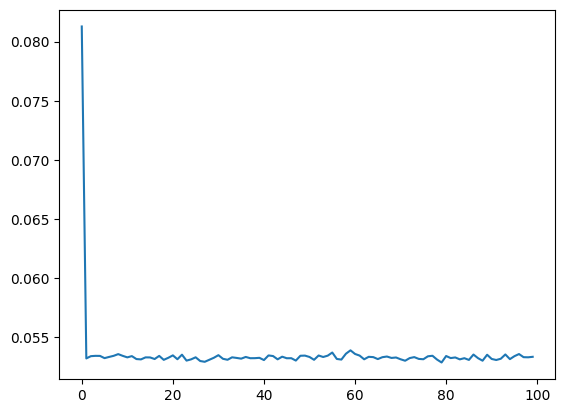

In [256]:
plt.plot(reproduction_losses)


In [257]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)

In [258]:
vmin, vmax = -2.5, 2.5

tensor([[0.7053, 0.9729, 1.0196, 0.9917, 0.8230],
        [0.8605, 1.1202, 1.1507, 1.1023, 0.9415],
        [0.9465, 1.1176, 1.1478, 1.1001, 0.9023],
        [0.9264, 1.1000, 1.1153, 1.0294, 0.7906],
        [0.8238, 0.9749, 0.9961, 0.8766, 0.6292]])


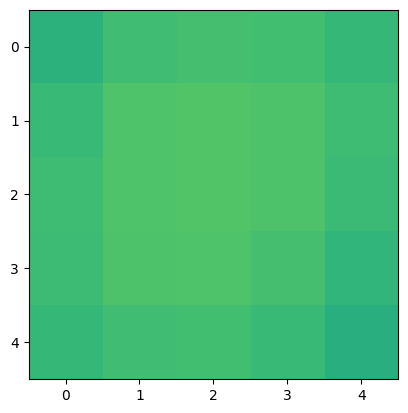

In [259]:
noise = torch.randn(1, latent_dim).to(device) 
res = model.Decoder(noise).view(5, 5).detach().cpu()
print(res)
plt.imshow(res, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

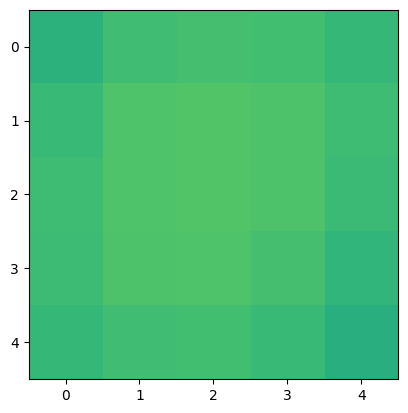

In [260]:
plt.imshow(generated_images[0].view(5, 5), norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

In [261]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(num_filters):
      idx = random.choice(range(len(generated_images)))
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[idx].cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

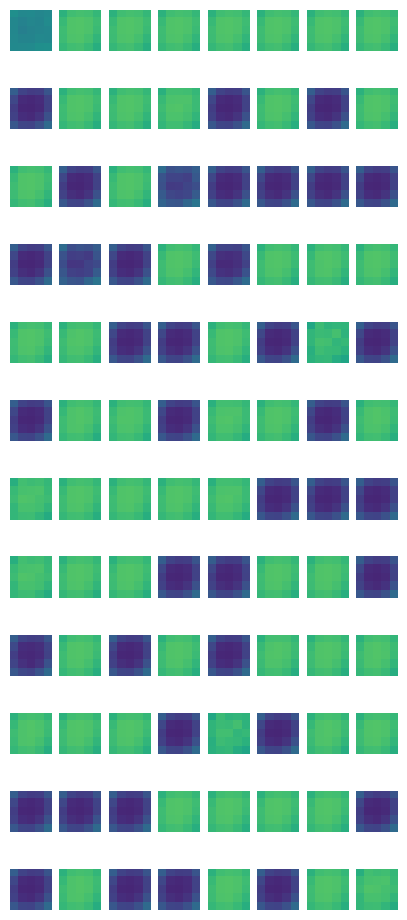

In [262]:
visualise_vae(100//num_filters, generated_images)

In [ ]:
for i in range(len(dataset)):
    print(i, "\n", torch.max(dataset[i]), "\n", torch.min(dataset[i]), "\n\n")

In [155]:
k = 33
print(torch.mean(dataset[100*k:100*(k+1)]))
print(torch.std(dataset[100*k:100*(k+1)]))

tensor(-0.1181, device='cuda:0')
tensor(1.3148, device='cuda:0')


In [136]:
def debug(x):
    for i in range(len(x)):
        print(i, "\n", torch.max(x[i]), "\n", torch.min(x[i]), "\n\n")

In [ ]:
debug(generated_images)